In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim

from src.features import build_features_op, utils, build_features_optim, build_features, build_features_optimizer
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.config.config import seed_everything, cfg
from src.visualization.visual import plot_label_counts

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

drop_feature = ['type']

# 데이터 전처리
train_data = pd.read_csv(r'data\raw\train_data.csv')
# train_data = utils.outlier_z_score_filter_df(train_data)
train_data = build_features_optimizer.create_derived_features(train_data)
train_data = train_data.drop(drop_feature, axis=1)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_optimizer.create_derived_features(test_data)
test_data = test_data.drop(drop_feature, axis=1)
test_data_raw = test_data.copy()

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

n_features = scaled_train_data.shape[1]
print(n_features)

scaled_train_data = scaled_train_data.values
scaled_test_data = scaled_test_data.values

# 데이터 로더
dataloader = DatasetLoader(scaled_train_data, scaled_test_data)
train_loader, test_loader = dataloader.load

# 학습 파라미터
model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=n_features-4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습
train(train_loader, model, criterion, optimizer)

# 예측
train_prediction, train_cosine = evaluation(train_loader, model)
print(min(train_cosine))
prediction, test_cosine = evaluation(test_loader, model, min(train_cosine))

# 제출
submission = prediction_to_csv(prediction)


15
Epoch [1/500], Loss: 0.1026847
Epoch [2/500], Loss: 0.0990227
Epoch [3/500], Loss: 0.0935229
Epoch [4/500], Loss: 0.0927786
Epoch [5/500], Loss: 0.0884527
Epoch [6/500], Loss: 0.0875932
Epoch [7/500], Loss: 0.0763289
Epoch [8/500], Loss: 0.0729058
Epoch [9/500], Loss: 0.0593454
Epoch [10/500], Loss: 0.0539171
Epoch [11/500], Loss: 0.0526086
Epoch [12/500], Loss: 0.0524580
Epoch [13/500], Loss: 0.0482319
Epoch [14/500], Loss: 0.0455381
Epoch [15/500], Loss: 0.0439585
Epoch [16/500], Loss: 0.0432494
Epoch [17/500], Loss: 0.0402072
Epoch [18/500], Loss: 0.0382123
Epoch [19/500], Loss: 0.0323041
Epoch [20/500], Loss: 0.0271724
Epoch [21/500], Loss: 0.0217160
Epoch [22/500], Loss: 0.0182045
Epoch [23/500], Loss: 0.0173656
Epoch [24/500], Loss: 0.0188475
Epoch [25/500], Loss: 0.0179492
Epoch [26/500], Loss: 0.0137623
Epoch [27/500], Loss: 0.0154170
Epoch [28/500], Loss: 0.0141542
Epoch [29/500], Loss: 0.0134489
Epoch [30/500], Loss: 0.0127699
Epoch [31/500], Loss: 0.0130830
Epoch [32/500]

In [2]:

test_data['label'] = prediction
test_data['treshold'] = test_cosine
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [3]:
train_data.corr()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,pressure_flow_ratio,vibe_voltage_ratio,performance_index,pressure_load_ratio,vibe_rpm_ratio,vibe+rpm_temp,temp_diff,rpm*inflow
air_inflow,1.000000,0.636467,NaN,0.994585,0.549101,0.659138,0.347755,-0.736625,-0.511076,-0.039302,-0.458013,-0.054501,0.463060,-0.429535,0.826806
air_end_temp,0.636467,1.000000,NaN,0.703042,0.990302,0.999506,0.273699,-0.544219,-0.371593,-0.749002,-0.931031,0.669942,0.964071,-0.967145,0.160828
out_pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motor_current,0.994585,0.703042,NaN,1.000000,0.619536,0.723685,0.353014,-0.759055,-0.524039,-0.119870,-0.527715,0.021409,0.536036,-0.510070,0.779784
motor_rpm,0.549101,0.990302,NaN,0.619536,1.000000,0.986419,0.237544,-0.438573,-0.313156,-0.828759,-0.954596,0.747805,0.988512,-0.985236,0.044719
motor_temp,0.659138,0.999506,NaN,0.723685,0.986419,1.000000,0.282746,-0.561815,-0.381640,-0.729877,-0.924914,0.649317,0.957418,-0.958681,0.191433
motor_vibe,0.347755,0.273699,NaN,0.353014,0.237544,0.282746,1.000000,-0.305154,0.518915,-0.078801,-0.229740,-0.265611,0.209524,-0.190395,0.277077
pressure_flow_ratio,-0.736625,-0.544219,NaN,-0.759055,-0.438573,-0.561815,-0.305154,1.000000,0.595911,-0.052054,0.366567,0.087901,-0.365623,0.381765,-0.709337
vibe_voltage_ratio,-0.511076,-0.371593,NaN,-0.524039,-0.313156,-0.381640,0.518915,0.595911,1.000000,-0.019724,0.247186,-0.197415,-0.266041,0.276587,-0.461763
performance_index,-0.039302,-0.749002,NaN,-0.119870,-0.828759,-0.729877,-0.078801,-0.052054,-0.019724,1.000000,0.871529,-0.920679,-0.885675,0.876176,0.495222


In [4]:
yes.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,pressure_flow_ratio,vibe_voltage_ratio,performance_index,pressure_load_ratio,vibe_rpm_ratio,vibe+rpm_temp,temp_diff,rpm*inflow,label,treshold
count,15.000000,15.000000,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000
mean,2.386000,51.597333,7.000000e-01,30.893333,2527.666667,68.085333,3.405333,0.329654,0.118251,0.000807,0.763834,724.561929,36.288724,16.488000,0.000944,0.0,0.999941
std,0.748282,9.906409,1.149190e-16,9.686044,792.453033,8.804113,0.439559,0.128177,0.028355,0.000111,0.297136,147.725148,7.380615,1.102304,0.000001,0.0,0.000042
min,1.220000,36.160000,7.000000e-01,15.800000,1293.000000,54.370000,2.720000,0.208333,0.091578,0.000681,0.483203,475.367647,23.831525,15.060000,0.000942,0.0,0.999836
25%,1.825000,44.175000,7.000000e-01,23.640000,1934.000000,61.490000,3.075000,0.235300,0.097405,0.000721,0.545474,628.246032,31.467416,15.625000,0.000943,0.0,0.999942
50%,2.430000,52.230000,7.000000e-01,31.510000,2578.000000,68.640000,3.430000,0.288066,0.108854,0.000786,0.666455,751.603499,37.608246,16.410000,0.000944,0.0,0.999952
75%,2.975000,59.375000,7.000000e-01,38.500000,3150.000000,75.000000,3.750000,0.385370,0.130490,0.000879,0.892674,839.992462,42.049620,17.315000,0.000945,0.0,0.999967
max,3.360000,64.450000,7.000000e-01,43.460000,3556.000000,79.510000,3.980000,0.573770,0.172152,0.000994,1.329114,893.467337,44.773991,18.210000,0.000946,0.0,0.999987


In [5]:
no.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,pressure_flow_ratio,vibe_voltage_ratio,performance_index,pressure_load_ratio,vibe_rpm_ratio,vibe+rpm_temp,temp_diff,rpm*inflow,label,treshold
count,4.000000,4.000000,4.0,4.00000,4.00000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000
mean,1.895000,49.400000,0.7,29.03000,2272.00000,65.247500,3.46250,0.391599,0.123819,0.000707,0.766884,646.150900,34.332991,15.847500,0.000834,1.0,0.987978
std,0.586373,8.785522,0.0,8.98232,702.97321,7.811241,0.39195,0.096403,0.019726,0.000077,0.188861,118.107673,6.034729,0.974282,0.000001,0.0,0.004262
min,1.480000,43.150000,0.7,22.64000,1772.00000,59.690000,3.18000,0.253623,0.095553,0.000595,0.496689,557.232704,29.739990,14.410000,0.000832,1.0,0.984541
25%,1.570000,44.567500,0.7,24.08750,1885.25000,60.950000,3.24750,0.365130,0.118518,0.000692,0.715610,580.363222,30.975856,15.685000,0.000834,1.0,0.985331
50%,1.670000,46.045000,0.7,25.60000,2003.50000,62.265000,3.31500,0.419899,0.129631,0.000733,0.821643,604.155745,32.218288,16.220000,0.000835,1.0,0.986658
75%,1.995000,50.877500,0.7,30.54250,2390.25000,66.562500,3.53000,0.446368,0.134932,0.000749,0.872916,669.943423,35.575424,16.382500,0.000835,1.0,0.989305
max,2.760000,62.360000,0.7,42.28000,3309.00000,76.770000,4.04000,0.472973,0.140459,0.000767,0.927562,819.059406,43.155399,16.540000,0.000835,1.0,0.994054


In [6]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()

Chunk 0: 143 labels with value 1


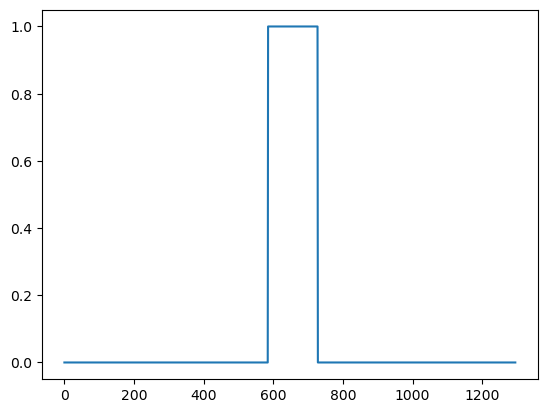

Chunk 1: 2 labels with value 1


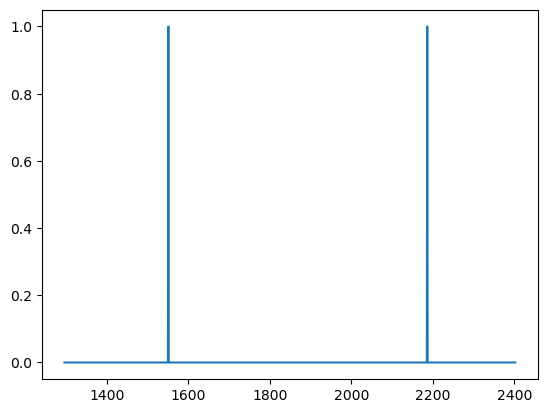

Chunk 2: 41 labels with value 1


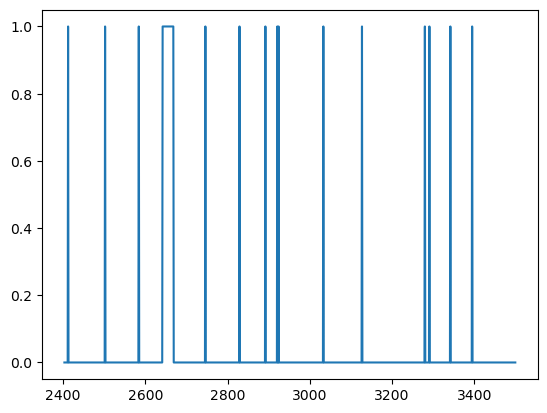

Chunk 3: 26 labels with value 1


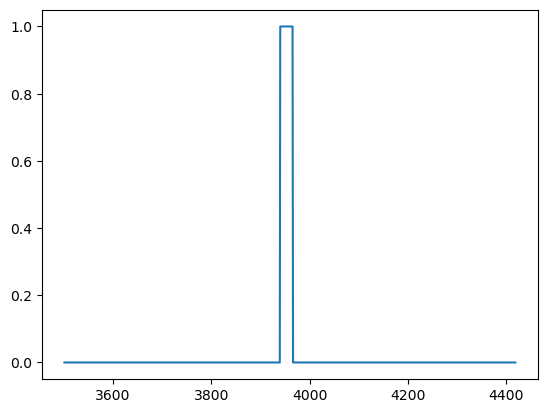

Chunk 4: 13 labels with value 1


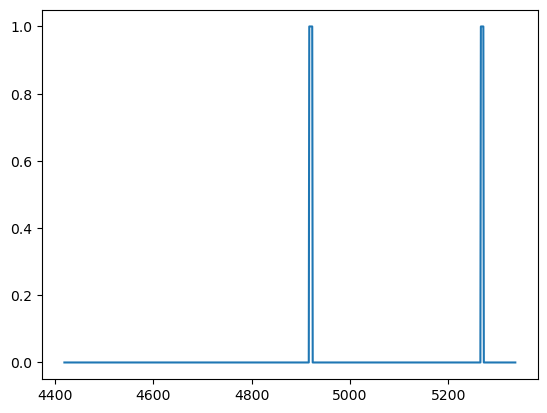

Chunk 5: 29 labels with value 1


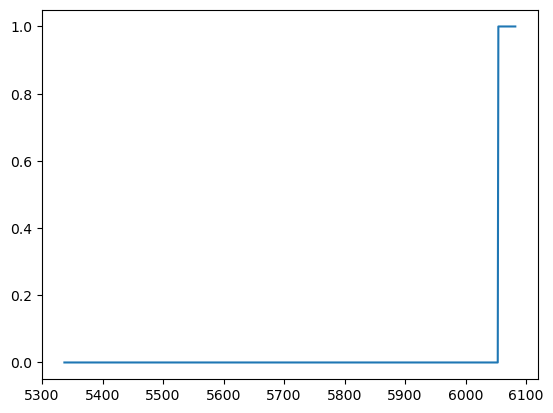

Chunk 6: 102 labels with value 1


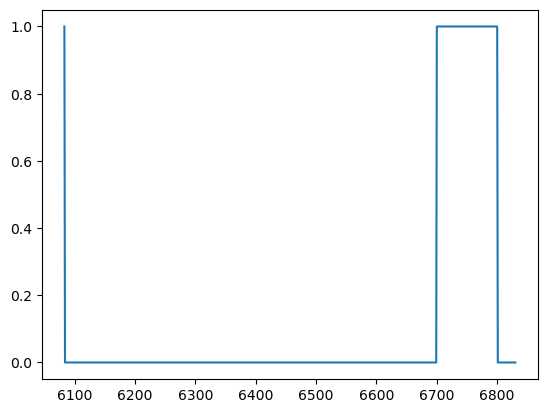

Chunk 7: 4 labels with value 1


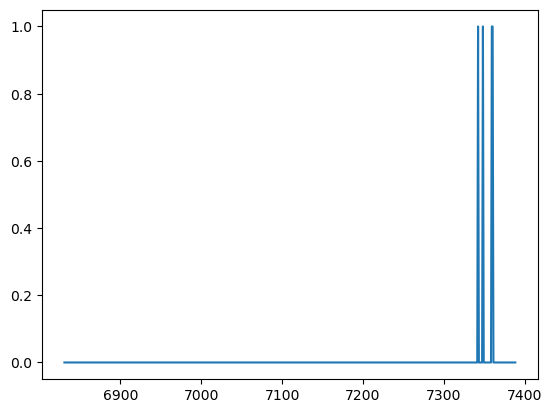

In [7]:
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(prediction))]
plot_label_counts(submission, ranges)

In [8]:
train_data['label'] = train_cosine

In [9]:
x_train = train_data.drop('label', axis=1)
y_train = train_data['label']

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(test_data)

In [72]:
test_data['label'] = y_pred

In [75]:
test_data[test_data['label']>0.7]

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,pressure_flow_ratio,vibe_voltage_ratio,performance_index,pressure_load_ratio,vibe_rpm_ratio,vibe+rpm_temp,temp_diff,rpm*inflow,label
0,2.5100,53.2800,0.7000,32.5400,2662.0000,69.5800,3.4800,0.2789,0.1069,0.0008,0.6454,764.9425,38.3081,16.3000,3.4809,0.9999
1,2.6600,55.2400,0.7000,34.4500,2819.0000,71.3200,3.5700,0.2632,0.1036,0.0008,0.6096,789.6359,39.5761,16.0800,3.5709,0.9999
2,1.7200,42.7400,0.7000,22.2300,1819.0000,60.2100,3.0100,0.4070,0.1354,0.0009,0.9447,604.3189,30.2609,17.4700,3.0109,0.9998
3,2.2000,49.1500,0.7000,28.5000,2332.0000,65.9100,3.3000,0.3182,0.1158,0.0008,0.7368,706.6667,35.4316,16.7600,3.3009,0.9999
4,2.0600,47.2800,0.7000,26.6700,2182.0000,64.2400,3.2100,0.3398,0.1204,0.0008,0.7874,679.7508,34.0163,16.9600,3.2109,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,2.1200,48.0800,0.7000,27.4500,2246.0000,64.9600,3.2500,0.3302,0.1184,0.0008,0.7650,691.0769,34.6252,16.8800,3.2509,0.9999
7385,1.4800,39.6300,0.7000,19.1900,1570.0000,57.4400,2.8700,0.4730,0.1496,0.0009,1.0943,547.0383,27.3828,17.8100,2.8709,0.9999
7386,1.5600,40.6100,0.7000,20.1500,1649.0000,58.3200,2.9200,0.4487,0.1449,0.0009,1.0422,564.7260,28.3251,17.7100,2.9209,0.9998
7387,1.5900,40.9900,0.7000,20.5200,1679.0000,58.6600,2.9300,0.4403,0.1428,0.0009,1.0234,573.0375,28.6725,17.6700,2.9309,0.9998


(array([1.000e+00, 0.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 6.000e+00,
        3.000e+01, 1.400e+01, 3.000e+00, 7.328e+03]),
 array([0.9966175 , 0.9969456 , 0.9972738 , 0.997602  , 0.9979301 ,
        0.99825823, 0.9985864 , 0.9989146 , 0.9992427 , 0.99957085,
        0.999899  ], dtype=float32),
 <BarContainer object of 10 artists>)

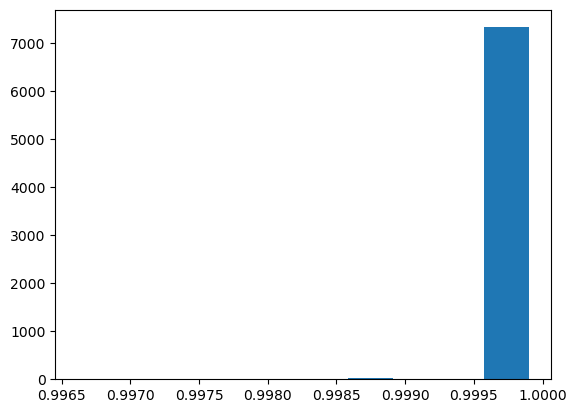

In [74]:
plt.hist(test_data.label)